In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from helper import get_wsj, save_obj, load_obj
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.initializers import Constant
from keras.layers import Dense, Input, GRU, TimeDistributed, Bidirectional, Dropout, LSTM
from keras.models import Model
plt.rcdefaults()

Using TensorFlow backend.


In [2]:
# Loading news article summaries and belonging news sections
articles = load_obj("articles.pkl")
sections = load_obj("sections.pkl")

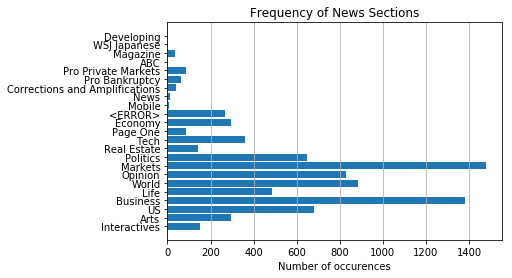

In [3]:
# Checking how many different sections exist and how often they are used
available_categories = []
for sec in sections:
    if sec not in available_categories:
        available_categories.append(sec)

number_of_occurences = []
for cat in available_categories:
    number_of_occurences.append(sections.count(cat))

plt.barh(np.arange(len(available_categories)), number_of_occurences)
plt.yticks(np.arange(len(available_categories)), available_categories)
plt.title("Frequency of News Sections")
plt.xlabel("Number of occurences")
plt.grid(axis="x")
plt.show()

In [4]:
# Filter out sections that rarely occure

MINIMUM_OCCURENCES = 100

cleaned_articles = []
cleaned_sections = []
for a, s in list(zip(articles, sections)):
    if (dict(zip(available_categories, number_of_occurences))[s] >= MINIMUM_OCCURENCES) and (s != "<ERROR>"):
        cleaned_articles.append(a)
        cleaned_sections.append(s)
               
print("Deleted {} articles. There are still {} articles left".format(len(articles) - len(cleaned_articles), len(cleaned_articles)))

Deleted 603 articles. There are still 7623 articles left


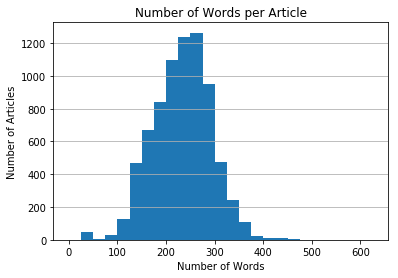

In [5]:
# Plot number of words per article

plt.hist([len(a) for a in cleaned_articles],25)
plt.title("Number of Words per Article")
plt.xlabel("Number of Words")
plt.ylabel("Number of Articles")
plt.grid(axis="y")
plt.show()

In [6]:
# Dictionaries for translating sections into index and back

label_to_index = {}
for s in cleaned_sections:
    if s not in label_to_index:
        label_to_index[s] = len(label_to_index)

index_to_label = dict((i,l) for l, i in label_to_index.items())

# List with all available sections that occure in cleaned dataset
labels = [label_to_index[s] for s in cleaned_sections]

In [7]:
# Maximum number of unique words that should be considered
MAX_NUM_WORDS = 20000

# Number of words per article that are used. If an article has less words,
# it is padded, if an article consists of more words, it is truncated
SEQUENCE_LENGTH = 200

# Tokenize words
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(cleaned_articles)

# Transform articles into sequences of tokens
sequences = tokenizer.texts_to_sequences(cleaned_articles)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Padd or truncate articles of length != SEQUENCE_LENGTH
tokenized_articles = pad_sequences(sequences, maxlen=SEQUENCE_LENGTH, padding='pre', truncating='post')

# Tokenize labels (sections)
labels = to_categorical(labels)
print('Shape of data tensor:', tokenized_articles.shape)
print('Shape of label tensor:', labels.shape)

Found 22334 unique tokens.
Shape of data tensor: (7623, 200)
Shape of label tensor: (7623, 12)


In [8]:
# Load GloVe word vectors

embeddings_index = {}
with open("glove.6B.100d.txt", encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s GloVe word vectors.' % len(embeddings_index))

Found 400000 GloVe word vectors.


In [14]:
# Prepare embedding matrix

embedding_dim = embeddings_index["sunday"].shape[0]

print('Preparing embedding matrix.')

num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Load pre-trained word embeddings into an Embedding layer
embedding_layer = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=SEQUENCE_LENGTH,
                            trainable=False)

Preparing embedding matrix.


In [15]:
# Neural Network Model

model_input = Input(shape=(SEQUENCE_LENGTH,), dtype='int32')
embed = embedding_layer(model_input)
fc = TimeDistributed(Dense(100, activation="relu"))(embed)
rnn = Bidirectional(LSTM(units=100, return_sequences=False))(fc)
drop_1 = Dropout(0.5)(rnn)
den = Dense(512, activation="relu")(drop_1)
drop_2= Dropout(0.5)(den)
out = Dense(len(label_to_index), activation="softmax")(drop_2)

model = Model(model_input, out)
model.summary()
model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          2000100   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 100)          10100     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [16]:
history = model.fit(tokenized_articles, labels,
          validation_split=0.25,
          shuffle=True,
          batch_size=1024,
          epochs=50,
          verbose=2)

Train on 5717 samples, validate on 1906 samples
Epoch 1/50
 - 16s - loss: 2.3284 - acc: 0.1728 - val_loss: 2.2331 - val_acc: 0.2041
Epoch 2/50
 - 8s - loss: 2.1992 - acc: 0.2209 - val_loss: 2.2423 - val_acc: 0.2167
Epoch 3/50
 - 8s - loss: 2.1055 - acc: 0.2398 - val_loss: 2.0812 - val_acc: 0.3075
Epoch 4/50
 - 8s - loss: 2.0627 - acc: 0.2872 - val_loss: 1.7787 - val_acc: 0.4203
Epoch 5/50
 - 8s - loss: 1.9003 - acc: 0.3351 - val_loss: 1.6985 - val_acc: 0.4176
Epoch 6/50
 - 8s - loss: 1.7628 - acc: 0.3860 - val_loss: 1.8168 - val_acc: 0.3767
Epoch 7/50
 - 8s - loss: 1.7562 - acc: 0.3799 - val_loss: 1.5935 - val_acc: 0.4675
Epoch 8/50
 - 8s - loss: 1.7014 - acc: 0.4146 - val_loss: 1.4941 - val_acc: 0.5047
Epoch 9/50
 - 8s - loss: 1.5710 - acc: 0.4599 - val_loss: 1.4996 - val_acc: 0.4927
Epoch 10/50
 - 8s - loss: 1.5052 - acc: 0.4819 - val_loss: 1.6165 - val_acc: 0.4517
Epoch 11/50
 - 8s - loss: 1.5853 - acc: 0.4663 - val_loss: 1.3229 - val_acc: 0.5540
Epoch 12/50
 - 8s - loss: 1.4344 - a

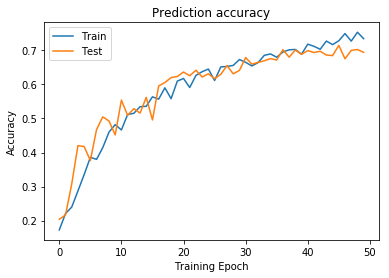

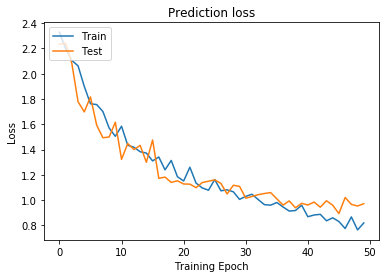

In [17]:
# Plot training and validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Prediction accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Training Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training and validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Prediction loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [24]:
def predict_news_section(article):
    """Predicts the belonging section for a given news article.
    
    Ags:
        article (str): Unprocessed text of a news article.
        
    Returns:
        section (str):        The name of the predicted news section.
        prob (numpy.ndarray): Predicted probability for each section.
        
    """
    seq = tokenizer.texts_to_sequences([article])
    padd_seq = pad_sequences(seq, maxlen=SEQUENCE_LENGTH, padding='pre', truncating='pre')
    prob = model.predict(padd_seq).flatten()
    return index_to_label[np.argmax(prob)], prob 

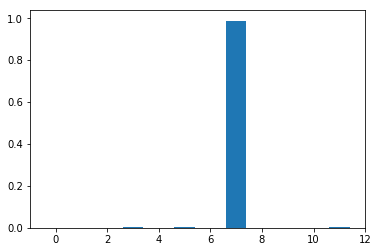

News section:  Markets
Predicted news section:  Markets


In [26]:
# Predict the section for a randomly chosen article from the dataset

N = np.random.randint(0, len(cleaned_sections))

predicted_section, probability = predict_news_section(cleaned_articles[N])
plt.bar(np.arange(len(probability)), probability)
plt.show()
print("News section: ", cleaned_sections[N])
print("Predicted news section: ", predicted_section)